In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Importing the dataset
boston = pd.read_csv('Boston-filtered.csv')

In [3]:
# Splitting into data and labels
y = boston['MEDV'].values
X = boston.drop('MEDV', axis = 1).to_numpy()

In [4]:
def train_test_split(X, y, test_size = .33, random_state = 420):
	"""Utility function to split a dataset into train and test folds.
	
	Args:
	X (ndarray): Array of unlabeled data
	y (ndarray): Array of labels for X
	test_size (float): Float between 0 and 1. Determines the size of the test set
	random_state(int): Random state, for reproducibility, or generating different splits
	
	Returns:
	X_train, X_test, y_train, y_test(ndarrrays): Arrays of train/test split Xs and ys
	"""
	data = np.concatenate([X, y[:,None]], axis = 1)
	np.random.seed(random_state)
	np.random.shuffle(data)
	print(f'{data = }')
	test_data = data[:int(data.shape[0] * test_size), :]
	train_data = data[int(data.shape[0] * test_size):, :]
	X_test = test_data[:, :-1]
	y_test = test_data[:,-1]
	X_train = train_data[:,:-1]
	y_train = train_data[:,-1]
	return X_train, X_test, y_train, y_test

In [5]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 420)

data = array([[4.15292e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        2.73800e+01, 8.50000e+00],
       [2.73100e-02, 0.00000e+00, 7.07000e+00, ..., 1.78000e+01,
        9.14000e+00, 2.16000e+01],
       [3.15000e-02, 9.50000e+01, 1.47000e+00, ..., 1.70000e+01,
        4.56000e+00, 3.49000e+01],
       ...,
       [6.96215e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        1.71100e+01, 1.51000e+01],
       [9.16400e-02, 0.00000e+00, 1.08100e+01, ..., 1.92000e+01,
        5.52000e+00, 2.28000e+01],
       [5.58107e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        1.62200e+01, 1.43000e+01]])


# Kernel Ridge Regression
We need to define the gaussian Kernel and Kernel matrix we will use for regression.

In [6]:
def gaussian_kernel(x_i, x_j, sigma):
    """Computes the Gaussian kernel for the given x_i and x_j.

    Args:
        x_i, x_j (ndarrays): vectors of samples

    Returns:
        kernel (float): value of the Gaussian kernel for the given x_i, x_j
    """
    kernel = np.exp(-((np.linalg.norm(x_i - x_j)**2) / (2 * sigma**2)))
    return kernel


In [7]:
def kernel_matrix(data, sigma):
    """Given a dataset and a kernel function, returns the kernel matrix
    to be used in regression. Depends on the Gaussian Kernel function.
    
    Args:
        data (ndarray): The dataset which we want to compute the kernel matrix with, of shape (n_samples, n_features) 
        sigma (float): Value of sigma to compute the kernel function with.
    
    Returns:
        kernel_matrix (ndarray): Kernel matrix to be used in regression, of shape (n_samples, n_samples)
    """

    kernel_matrix = np.ones((data.shape[0], data.shape[0]))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            kernel_matrix[i,j] = gaussian_kernel(data[i,:], data[j,:], sigma)

    return kernel_matrix

In [8]:
# Initiating values for gamma and sigma
gammas = [2 ** -k for k in range(40, 25, -1)]
sigmas = [2 ** k for k in np.arange(7, 13.5, 0.5)]

# And also their coefficients for nicer plotting and reporting
gammas_coefs = [-k for k in range(40, 25, -1)]
sigmas_coefs = [k for k in np.arange(7, 13.5, 0.5)]

In [9]:
def kernel_ridge_regression(K, y, gamma):
    """Calculate the kernelised ridge regression coefficients for the given data.
    
    Args:
        K (ndarray): The kernel matrix for the data, of shape (n_samples, n_samples)
        y (ndarray): The y values for the data, of shape (n_samples, 1)
        gamma (float): Ridge regression hyperparameter
    
    Returns:
        alpha (ndarray): Array of regression coefficients for the given data, of shape (n_samples, )
    """

    alpha = np.linalg.inv(K + gamma * K.shape[0] * np.identity(K.shape[0])) @ y
    return alpha

In [10]:
def evaluate_kernel_ridge(X_train, X_test, y_test, alpha, sigma):
    """Returns the mse for a given Gaussian kernel ridge regression fit.
    Args:
        X_train (ndarray): The training data
        X_test (ndarray): The test data
        y_test (ndarray): The test labels
        alpha (ndarray): Parameters of kernel ridge regression fit
        sigma (float): Hyperparameter of the gaussian kernel to use in evaluation.
        
    Returns:
    mse (float): Mean s quared error of the given fit on the test data.
    """
    y_hats = np.zeros_like(y_test)
    for el in range(y_hats.shape[0]):
        for i in range(alpha.shape[0]):
            y_hats[el] += alpha[i] * gaussian_kernel(X_train[i,:], X_test[el,:], sigma)
    residuals  = y_test - y_hats
    mse = np.mean(residuals ** 2)
    return mse


In [11]:
def train_fit_evaluate(X_train, X_test, y_train, y_test, gammas, sigmas):
    """Runs a full cycle of Gaussian kernel ridge regression for combinations of given hyperparams. 
    Starts with training data, builds a Gaussian kernel, calculates parameters and evaluates the fit against test data. 
    Repeats the process for every possible combination of hyperparameters given.
    Returns a dictionary {hyperparams : mse}, and an array of error values.
    
    Args:
        X_train (ndarray): The training data
        X_test (ndarray): The test data
        y_train (ndarrays): The training labels
        y_test (ndarray): The test labels
        gammas (list): List of gammas hyperparameters to be used
        sigmas (list): List of sigmas hyperparameters to be used

    Returns:
        hyperparam_losses (dictionary): Dictionary of structure {(sigmas, gammas) : mse}
        losses_matrix (ndarray): Array of mse losses of shape (len(gammas), len(sigmas)), useful for plotting.
    """
    
    hyperparam_losses = {}      # initialise the dictionary of losses
    losses_matrix = np.ones((len(gammas), len(sigmas)))        # initialise the array of losses
    for g, gamma in enumerate(gammas):      # for each possible gamma
        # print(f'Running cycle {g} out of {len(gammas)}')
        for s, sigma in enumerate(sigmas):      # For each possible sigma
            matrix, alphas, mse = (None, None, None)
            matrix = kernel_matrix(X_train, sigma)      # Create kernel matrix
            alphas = kernel_ridge_regression(matrix, y_train, gamma)    # Compute parameters
            mse = evaluate_kernel_ridge(X_train, X_test, y_test, alphas, sigma)     # Evaluate the fit
            hyperparam_losses[(gamma, sigma)] = mse     # Store hyperparams : mse in a dictionary
            losses_matrix[g,s] = mse    # Store also in a matrix indexed by the hyperparams
    return hyperparam_losses, losses_matrix

In [12]:
def cross_validation_split(data, k_splits):
    """Splits the dataset provided into k_splits of indices to perform cross validation_indexes
    
    Args:
        data (ndarray): The dataset to split
        k_splits (int): The number of cross validation folds to generate indices for
    
    Returns:
        list_of_folds: list of lists containing n = k_folds (train_indices, validation_indices) tuples of indices.
                        Can be used to index the data when performing cross validation"""
    # Initialise indices
    indexes = np.array(list(range(data.shape[0])))

    # Shuffle indices
    np.random.shuffle(indexes)

    # Split into k folds
    split_list = np.split(indexes, 5)

    # Initialise list of lists
    list_of_folds = []

    # Fill list of folds with tuples of (train_indices, validation_indices)
    for i in range(k_splits):
        temp = split_list.copy()
        validation_indexes = list(split_list[i])
        temp.pop(i)
        train_indexes = list(np.concatenate(temp, axis = 0))
        list_of_folds.append((train_indexes, validation_indexes))
    return list_of_folds

In [13]:
# ATTENTION: This takes up to 15 minutes to run

def cross_validate(X_train, y_train, n_splits, sigmas, gammas):
    """ Performs k-fold cross validation given a list of hyperparameters sigmas and gammas. Computes the MSE
    for each combination of parameters in Gaussian kernel ridge regression. Returns a dictionary where parameters are the keys
    and MSE is the value, and also returns a matrix with all MSE values.

    Args:
        X_train (ndarray): training data input vector of shape (n_samples, n_features)
        y_train (ndarray): training vector of measurements of shape (n_samples,)
        n_split (scalar): number of folds for k-fold validation
        sigmas (list): list of sigma hyperparameters
        gammas (list): list of gamma hyperparameters

    Returns:
        hyper_dictionary (dictionary): dictionary -> (gamma, sigma) : MSE
        hyper_losses_matrix (dictionary): matrix of MSEs of shape (len(gammas), len(sigmas))

    """

    # Initialize hyperparameter dictionary 
    hyper_dictionary = {}

    y_train = y_train[:, None] # To avoid indexing errors

    for i_split, (train_indices, val_indices) in enumerate(cross_validation_split(X_train, n_splits)):
        print(f'Running the {i_split + 1} split of cross validation')

        # Split the training data into cross-validation training and validation sets
        X_cv_train = X_train[train_indices,:]
        y_cv_train = y_train[train_indices,:]
        X_cv_val = X_train[val_indices,:]
        y_cv_val = y_train[val_indices,:]

        # Fit and evaluate kernelised ridge regression for all hyperparams combination
        losses, losses_matrix = train_fit_evaluate(X_cv_train, X_cv_val, y_cv_train, y_cv_val, gammas, sigmas)
        hyper_dictionary[f'{i_split + 1} validation'] = losses

        # Build matrix of losses. Will be useful for plotting and getting optimal values
        if i_split == 0:
            hyper_losses_matrix = losses_matrix
        elif i_split == 1:
            hyper_losses_matrix = np.stack((hyper_losses_matrix, losses_matrix), axis = 2)
        else:
            hyper_losses_matrix = np.concatenate((hyper_losses_matrix, losses_matrix[:,:, None]), axis = 2)
        
        
    return hyper_dictionary, hyper_losses_matrix

# Cross-validate
n_splits = 5
mse_all, losses_matrices = cross_validate(X_train, y_train, n_splits, sigmas, gammas)

Running the 1 split of cross validation
Running the 2 split of cross validation


KeyboardInterrupt: 

In [ ]:
# To save results if you run the above cell
parameters_df = pd.DataFrame(mse_all)
parameters_df.to_csv('parameters_df')
np.save('parameters_array', losses_matrices)

1 validation  2 validation  3 validation  \
9.094947e-13 128.000000    452.656521   2279.249950   3483.304970   
             181.019336    256.481427    452.008104   1539.176833   
             256.000000    104.571815     38.348557    847.739911   
             362.038672     62.942458     26.118897    244.215474   
             512.000000     45.026831     23.958296    109.102908   

                         4 validation  5 validation  
9.094947e-13 128.000000    797.246469   2311.771422  
             181.019336    809.842461    836.130226  
             256.000000     40.047780    215.690987  
             362.038672     61.403243     68.730922  
             512.000000     28.364319     38.885718

In [15]:
# Run this only if resuming and need to load the files
losses_matrices = np.load('parameters_array.npy')

In [16]:
# Finding the best hyperparameter combination
average_loss = np.mean(losses_matrices, axis = 2)
print(average_loss.shape)
argmin = np.unravel_index(np.argmin(average_loss, axis=None), average_loss.shape)
print(f'The lowest average loss across 5 folds of cross validation is \
{np.min(average_loss)}, and its argmin is {argmin}')
print(f'This means that the best gamma is 2^{gammas_coefs[argmin[0]]}, and the best sigma is 2^{sigmas_coefs[argmin[1]]}')

(15, 13)
The lowest average loss across 5 folds of cross validation is 15.459713929709332, and its argmin is (11, 5)
This means that the best gamma is 2^-29, and the best sigma is 2^9.5


In [17]:
# Defining axes for plotting
z = average_loss.ravel()
x = np.array(sigmas_coefs * len(gammas)) # x will just be the list of sigmas repeated len(gammas) times
temp = [[i] * len(sigmas) for i in gammas_coefs] # temporary list of lists where we repeat each gamma for the given sigma
y = np.array([item for sublist in temp for item in sublist]) # flattening list of list and returning an array

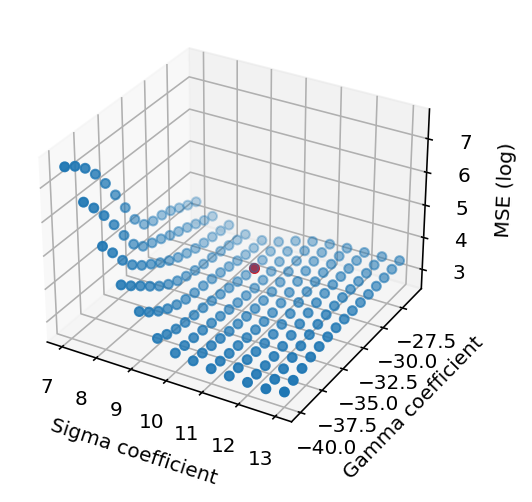

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlabel('MSE (log)')
ax.set_xlabel('Sigma coefficient')
ax.set_ylabel('Gamma coefficient')
ax.scatter(x,y, np.log(z));
ax.scatter(sigmas_coefs[argmin[1]], gammas_coefs[argmin[0]], np.min(np.log(average_loss)), color = 'red');

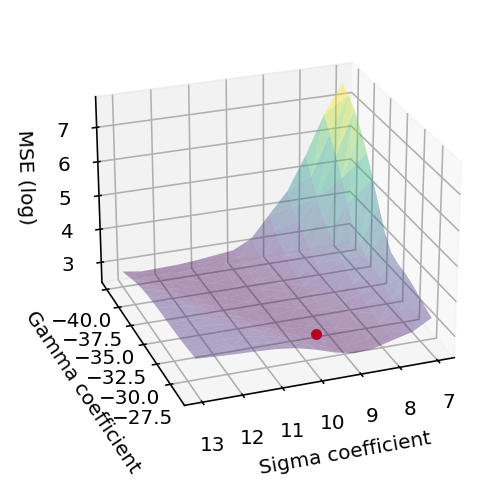

In [33]:
# does not work in colab : %matplotlib qt -> used to make plots interactive
# Uncomment the following line to make the plot interactive
# %matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_zlabel('MSE (log)')
ax.set_xlabel('Sigma coefficient')
ax.set_ylabel('Gamma coefficient')
ax.view_init(25, 70)
ax.plot_trisurf(x, y, np.log(z), cmap = 'viridis', alpha = 0.4);
ax.scatter(sigmas_coefs[argmin[1]], gammas_coefs[argmin[0]], (np.min(np.log(average_loss))), color = 'red');

# rotate the axes and update: use only with matplotlib qt
# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
def train_fit_evaluate_train(X_train, y_train, gammas, sigmas):
    """Runs a full cycle of Gaussian kernel ridge regression for combinations of given hyperparams. 
    Starts with training data, builds a Gaussian kernel, calculates parameters and evaluates the fit on 
    the same training data, returning the training error. 
    Repeats the process for every possible combination of hyperparameters given.
    Returns a dictionary {hyperparams : mse}, and an array of error values
    Note: differs from the 'train_fit_evaluate' function in that this function calculates
    losses and evaluates fits on the training data only.

    Args:
        X_train (ndarray): The training data
        y_train (ndarrays): The training labels
        gammas (list): List of gammas hyperparameters to be used
        sigmas (list): List of sigmas hyperparameters to be used

    Returns:
        hyperparam_losses (dictionary): Dictionary of structure {(sigmas, gammas) : mse}
        losses_matrix (ndarray): Array of mse losses of shape (len(gammas), len(sigmas)), useful for plotting.
    """
    
    hyperparam_losses = {}      # initialise the dictionary of losses
    losses_matrix = np.ones((len(gammas), len(sigmas)))        # initialise the array of losses
    for g, gamma in enumerate(gammas):      # for each possible gamma
        print(f'Running cycle {g} out of {len(gammas)}')
        for s, sigma in enumerate(sigmas):      # For each possible sigma
            matrix, alphas, mse = (None, None, None)
            matrix = kernel_matrix(X_train, sigma)      # Create kernel matrix
            alphas = kernel_ridge_regression(matrix, y_train, gamma)    # Compute parameters
            mse = evaluate_kernel_ridge(X_train, X_train, y_train, alphas, sigma)     # Evaluate the fit
            hyperparam_losses[(gamma, sigma)] = mse     # Store hyperparams : mse in a dictionary
            losses_matrix[g,s] = mse    # Store also in a matrix indexed by the hyperparams
    return hyperparam_losses, losses_matrix

In [ ]:
# Doing a fit with the best parameters
average_loss = np.mean(losses_matrices, axis = 2)
argmin = np.unravel_index(np.argmin(average_loss, axis=None), average_loss.shape)
best_gamma = gammas[argmin[0]]
best_sigma = sigmas[argmin[1]]
losses_test, losses_matrix_test = train_fit_evaluate(X_train, X_test, y_train, y_test, [best_gamma], [best_sigma])
print(f'Loss with best parameters on the test set is {np.squeeze(losses_matrix_test)}')
losses_train, losses_matrix_train = train_fit_evaluate_train(X_train, y_train, [best_gamma], [best_sigma])
print(f'Loss with best parameters on the train set is {np.squeeze(losses_matrix_train)}')
print(f'Is train loss better than test loss? {losses_matrix_train < losses_matrix_test}')

Loss with best parameters on the test set is 8.385440465802128
Running cycle 0 out of 1
Loss with best parameters on the train set is 10.351202058570067
Is train loss better than test loss? [[False]]


# Point d)
Repeating everything with 20 random train / test splits

In [ ]:
# Helpers to save stuff after hours of running
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
# !!! ATTENTION: This takes around 5 hours to run
# In the code cell below you can load the pickled array of params

boston = pd.read_csv('Boston-filtered.csv')
y = boston['MEDV'].values
X = boston.drop('MEDV', axis = 1).to_numpy()

gammas = [2 ** -k for k in range(40, 25, -1)]
gammas_coefs = [-k for k in range(40, 25, -1)]
sigmas = [2 ** k for k in np.arange(7, 13.5, 0.5)]
sigmas_coefs = [k for k in np.arange(7, 13.5, 0.5)]

def solve_d(n_runs):
    
    best_hyper_params = {}
    losses = {}
    for i in range(n_runs):
        rand_n = np.random.randint(1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = rand_n)
        
        _, losses_matrices = cross_validate(X_train, y_train, n_splits, sigmas, gammas) # Perform cross validation on the params

        # Get the average cross validation error, and the parameters that correspond to it
        average_loss = np.mean(losses_matrices, axis = 2)
        argmin = np.unravel_index(np.argmin(average_loss, axis=None), average_loss.shape)
        best_gamma = gammas[argmin[0]]
        best_sigma = sigmas[argmin[1]]

        # Save this into a dictionary
        best_hyper_params[i+1] = (gammas_coefs[argmin[0]], sigmas_coefs[argmin[1]])

        # Fitting and getting train and test MSE for the best parameters
        _, losses_matrix_train = train_fit_evaluate_train(X_train, y_train, [best_gamma], [best_sigma])
        _, losses_matrix_test = train_fit_evaluate(X_train, X_test, y_train, y_test, [best_gamma], [best_sigma])
        losses[i+1] = (np.squeeze(losses_matrix_train), np.squeeze(losses_matrix_test))
        save_obj(best_hyper_params, "best_params_20") # Saving the objects at each run in case of interruptions
        save_obj(losses, 'losses_20')

        print(f'Finished running the {i+1}th random initialisation')

    return best_hyper_params, losses
best_hyper_params_20, best_losses_20 = solve_d(20)

Running the 1 split of cross validation


/var/folders/f6/j1x_q83x3yd443dft1xxml_h0000gn/T/ipykernel_92679/3027925669.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = boston.drop('MEDV', 1).to_numpy()


Running the 2 split of cross validation
Running the 3 split of cross validation
Running the 4 split of cross validation
Running the 5 split of cross validation
Running cycle 0 out of 1
Finished running the 1th random initialisation
Running the 1 split of cross validation
Running the 2 split of cross validation
Running the 3 split of cross validation
Running the 4 split of cross validation
Running the 5 split of cross validation
Running cycle 0 out of 1
Finished running the 2th random initialisation
Running the 1 split of cross validation
Running the 2 split of cross validation
Running the 3 split of cross validation
Running the 4 split of cross validation
Running the 5 split of cross validation
Running cycle 0 out of 1
Finished running the 3th random initialisation
Running the 1 split of cross validation
Running the 2 split of cross validation
Running the 3 split of cross validation
Running the 4 split of cross validation
Running the 5 split of cross validation
Running cycle 0 out of 1

In [ ]:
losses_20 = load_obj('losses_20')
best_params_20 = load_obj('best_params_20')

In [ ]:
train_losses = [losses_20[i][0].item() for i in range(1,21)]
mean_train = np.mean(train_losses)
std_train = np.std(train_losses)
print(f'Mean loss in the train set is {mean_train} +- {std_train}')
test_losses = [losses_20[i][1].item() for i in range(1,21)]
mean_test = np.mean(test_losses)
std_test = np.std(test_losses)
print(f'Mean loss in the test set is {mean_test} +- {std_test}')

Mean loss in the train set is 8.11981453150879 +- 1.1010898152540487
Mean loss in the test set is 12.740373539390951 +- 1.85748565001784


| MSE train    | MSE test |
| ----------- | ----------- |
| 8.11 +- 1.10   |    12.74 +- 1.85  |